In [31]:
import sys
from pathlib import Path

notebook_dir = Path().resolve()
target_path = notebook_dir.parent.parent / 'ml-xai'
sys.path.append(str(target_path))

import WISP.WISP as wisp
from WISP.WISP import *
from WISP.ml_helper import get_features

from dscribe.descriptors import MBTR

from ase.io import read
from ase import Atoms

import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from openbabel import pybel

from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator

# How to use WISP on your data to train a model for you  
### In case you’re curious or don’t yet have a model  


Arguments required for `WISP`:  
- working_dir (str): Directory for outputs (models, plots, CSVs).  
- input_dir (str): Path to the input CSV file.  
- ID_Column_Name (str): Name of the ID column in the CSV.  
- Smiles_Column_Name (str): Name of the SMILES column in the CSV.  
- Target_Column_Name (str): Name of the target column (regression or binary class).  

Example Command:  
* `abc = WISP('*working_dir*', '*input_dir*', '*name_col*', '*smiles_col*', '*target_col*')`



Standardization done


Seed set to 6
Seed set to 6
Seed set to 6
Seed set to 6
Seed set to 6
Seed set to 6


Best Model:  <WISP.chemprop.SklChemprop object at 0x306a19690>
With a MAE of:  0.009631588051787706
Feature:  smiles_std
Performance on test set(r2, R2, MAE, RMSE, Maximal Error, MSE): 0.903110510569422 ; 0.9018331066380607 ; 0.009734157229189352 ; 0.013423508104413699 ; 0.07421459894554139 ; 0.00018019056982926024


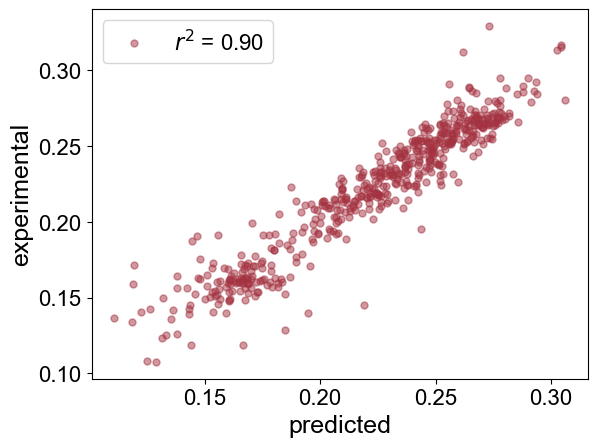

Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
Dropping last batch of size 1 to avoi

Atom Attribution done
Heatmaps have been created


MMPs created
For the training set:


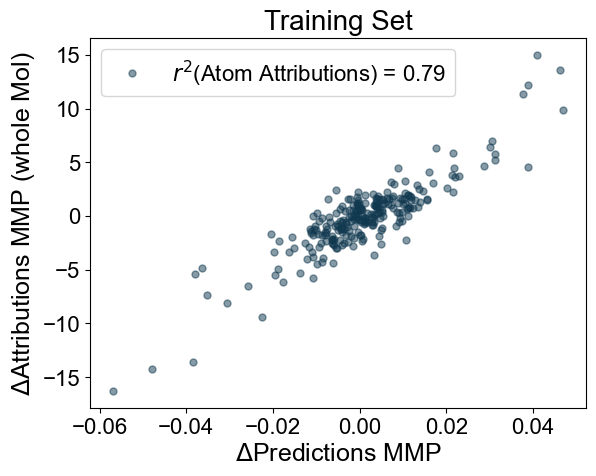

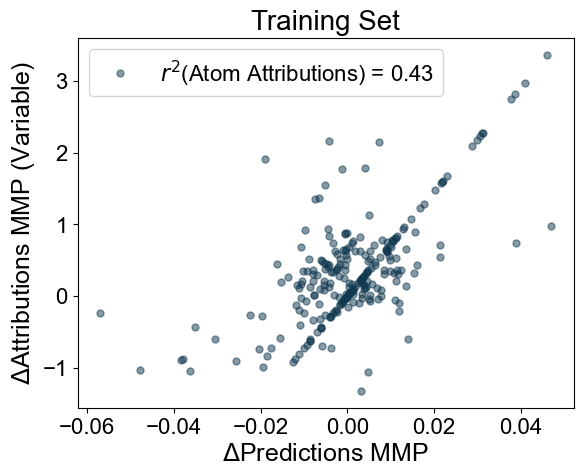

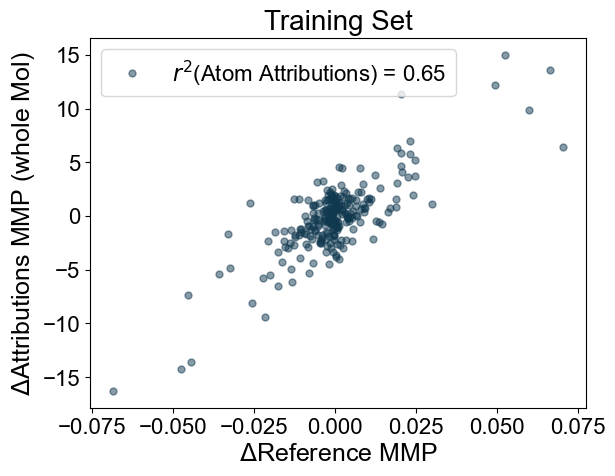

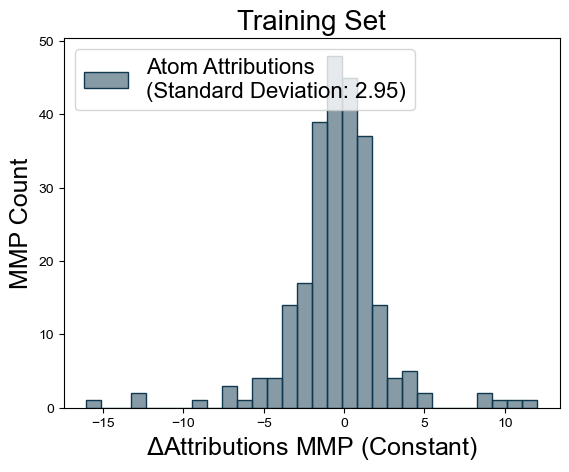

For the test set:


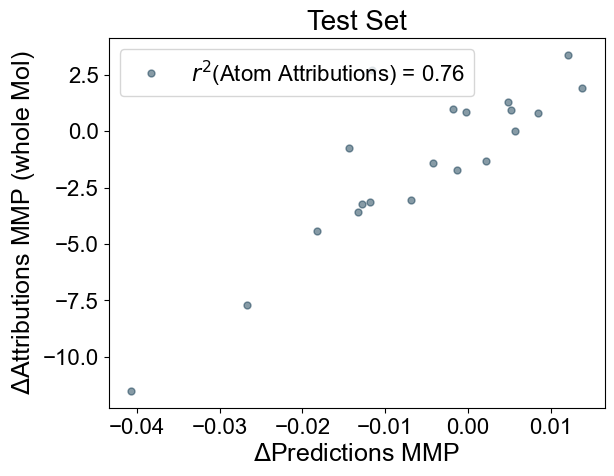

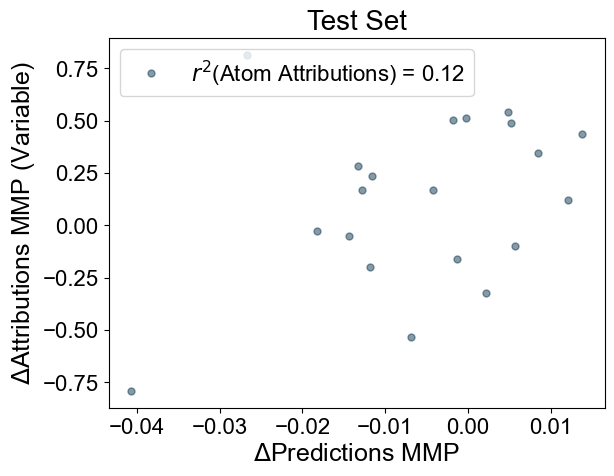

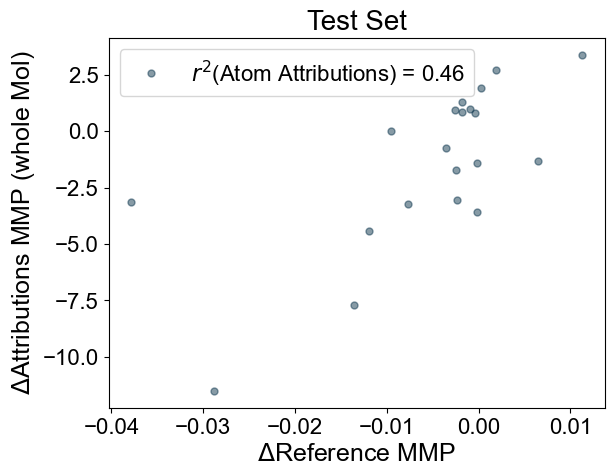

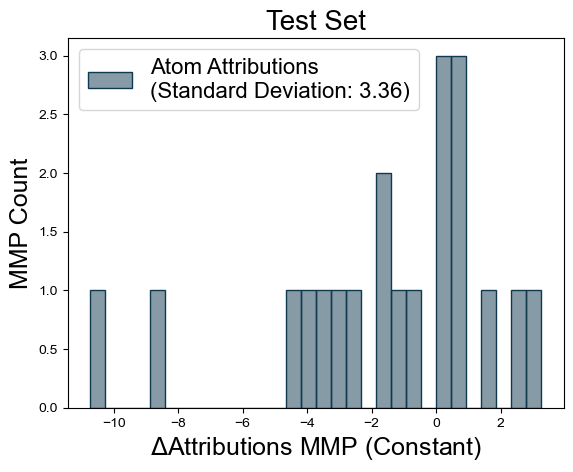

For the training set:
delta_sum_Atom Attributions Accuracy: 0.75
For the test set:
delta_sum_Atom Attributions Accuracy: 0.75
For the training set:
delta_sum_fragment_contributions_Atom Attributions Accuracy: 0.68
For the test set:
delta_sum_fragment_contributions_Atom Attributions Accuracy: 0.55
WISP done


In [ ]:
data = WISP('output/',
     'datasets/qm8_subset.csv',
     'mol_id',
     "smiles",
     'E1-CC2',
     )

# The following cells showcase some of the possible ways to use WISP with your own pretrained models

For the purpose of this first example, we will quickly train an arbitrary model on RDKit fingerprints as features and predicts the E1-CC2 energy.

The cell below generates the RDKit Fingerprints and trains a new model on the QM8 subset. The performance is evaluated by sklearns `cross_val_score` with r^2.  
The trained model is saved in the directory (can be changed to any other directory): *working_dir_rdkfp*.

Afterwards the trained model can be provided to WISP. (Beware: WISP will only consider your model if it is saved as `model.pkl`.)

In [ ]:
# Importing the dataframe
train_df = pd.read_csv('datasets/qm8_subset.csv')

# Generating the Fingerprints and saving them to the dataframe
rdk_fps = []
for smiles in train_df['smiles']:
    mol = Chem.MolFromSmiles(smiles)

    if mol is not None:
        generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=7, fpSize=2048)
        rdk_fp = generator.GetFingerprint(mol)

        arr = np.zeros((2048,), dtype=int)
        DataStructs.ConvertToNumpyArray(rdk_fp, arr)
        rdk_fps.append(arr)
    else:
        rdk_fps.append(np.zeros((2048,), dtype=int))
    
# Concatenating the Fingerprints into the dataframe
rdk_fp_df = pd.DataFrame({'RDK_FP': rdk_fps})
mod_train_df = pd.concat([train_df, rdk_fp_df], axis=1)

# Getting the targets (y_rdk_fp) and features (X_rdk_fp) from the dataframe
X_rdk_fp = get_features(mod_train_df, ['RDK_FP'])
y_rdk_fp = mod_train_df['E1-CC2'].values

kernel_1 = WhiteKernel() + RBF()

# Fit and evaluate the model
model_rdk_fp = make_pipeline(StandardScaler(), 
                      GaussianProcessRegressor(kernel=kernel_1, normalize_y=True, n_restarts_optimizer=5)
                      )

scores_r2 = cross_val_score(model_rdk_fp, X_rdk_fp, y_rdk_fp, cv=5, scoring='r2')
print(scores_r2)
print("Score of r² %0.2f with a standard deviation of %0.2f" % (scores_r2.mean(), scores_r2.std()))

model_rdk_fp.fit(X_rdk_fp, y_rdk_fp)

# Save your trained model
with open('output/model.pkl','wb') as f:
    pickle.dump(model_rdk_fp,f)

[0.84730413 0.86052567 0.88901803 0.81502075 0.83580448]
Score of r² 0.85 with a standard deviation of 0.02


### Executing WISP with the model trained on RDKit Fingerprints (model from cell above)

To use an already trained model with WISP, one needs to set the keyword argument `model_available=True`.  

When using `model_available=True` WISP will prompt you to input the name of the function that generates the features (in this case RDKit Fingerprints) from SMILES.  
-> In this case that function is already build into WISP: `get_RDK_fingerprint`  

In [ ]:
def get_RDK_fingerprint(smiles):
    """
    Calculates the RDK Fingerprint (Maximal pathlenght of 7 and 2048 bits) for the input smiles.

    Keyword arguments:
    -- smiles: Smiles for the which the fingerprint should be calculated.

    Returns:
    -- rdkit_fp: RDK Fingerprint as array to the respective smiles.
    """
    mol = Chem.MolFromSmiles(smiles, sanitize=False)
    Chem.SanitizeMol(mol)#to keep the explicit hydrogens
    
    if mol is not None:
        rdkit_fp = AllChem.RDKFingerprint(mol, maxPath=7)
        rdkit_fp = rdkit_fp.ToBitString()
        rdkit_fp = np.array(list(rdkit_fp))
        return rdkit_fp
    else:
        return None

Other build in functions that can be selected:  
- `get_MACCS_fingerprint`
- `get_morgan_fingerprint`

Please provide the name of the function to create the features based on smiles as input:
get_RDK_fingerprint


[00:23:57] Initializing MetalDisconnector
[00:23:57] Running MetalDisconnector
[00:23:57] Initializing Normalizer
[00:23:57] Running Normalizer
[00:23:57] Running LargestFragmentChooser
[00:23:57] Running Uncharger
[00:23:57] Initializing MetalDisconnector
[00:23:57] Running MetalDisconnector
[00:23:57] Initializing Normalizer
[00:23:57] Running Normalizer
[00:23:57] Initializing MetalDisconnector
[00:23:57] Running MetalDisconnector
[00:23:57] Initializing MetalDisconnector
[00:23:57] Running MetalDisconnector
[00:23:57] Initializing Normalizer
[00:23:57] Running Normalizer
[00:23:57] Running LargestFragmentChooser
[00:23:57] Running Uncharger
[00:23:57] Initializing MetalDisconnector
[00:23:57] Running MetalDisconnector
[00:23:57] Initializing Normalizer
[00:23:57] Running Normalizer
[00:23:57] Initializing Normalizer
[00:23:57] Running Normalizer
[00:23:57] Initializing MetalDisconnector
[00:23:57] Running MetalDisconnector
[00:23:57] Initializing Normalizer
[00:23:57] Running Norma

Standardization done
Atom Attribution done
RDKit Attribution done
Heatmaps have been created


MMPs created


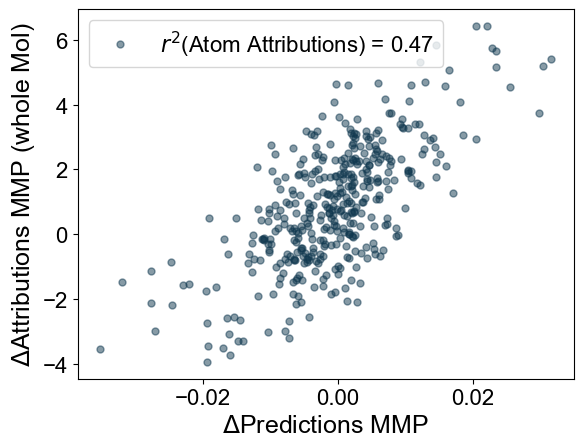

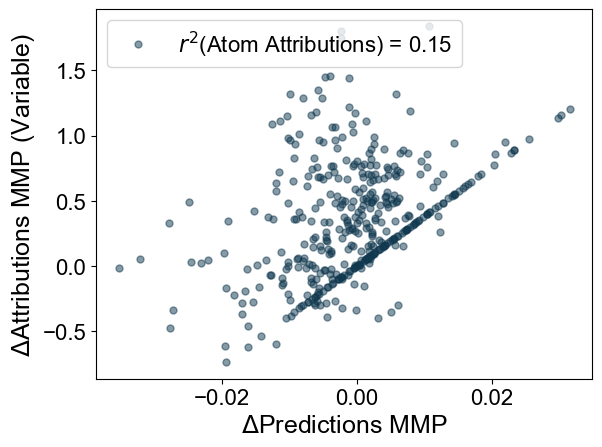

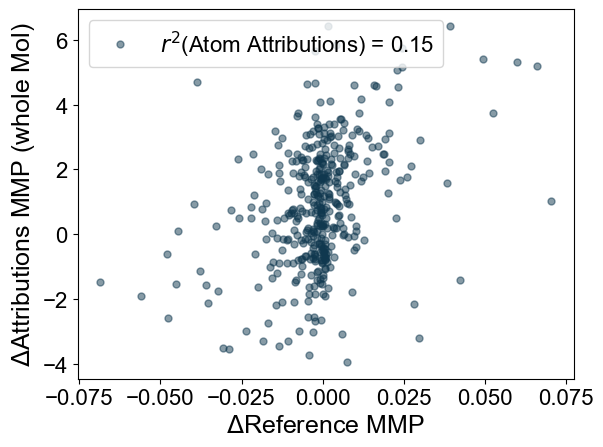

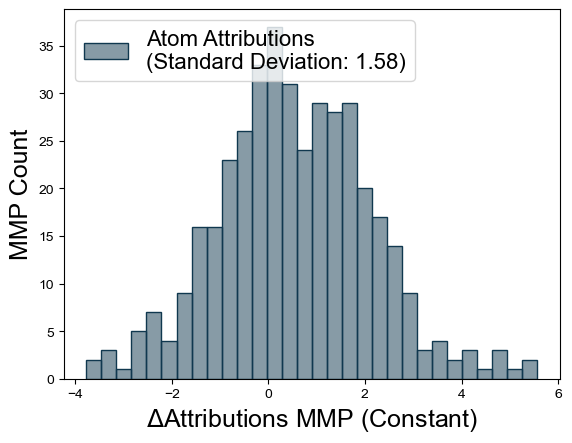

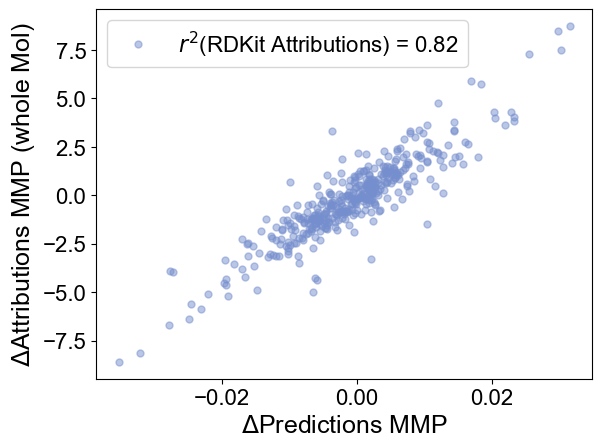

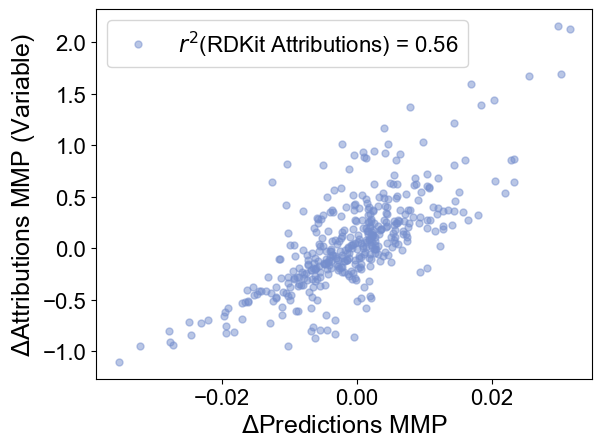

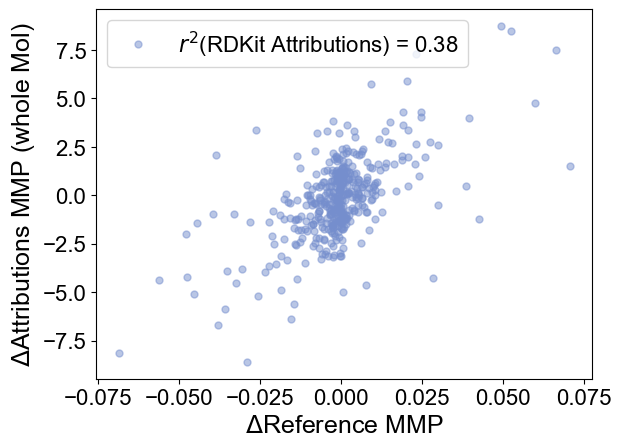

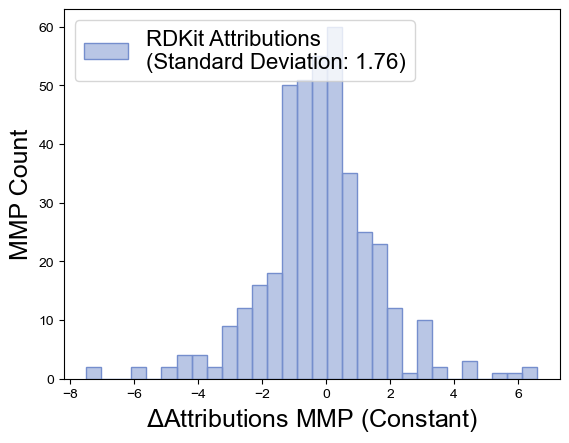

delta_sum_Atom Attributions Accuracy: 0.68
delta_sum_fragment_contributions_Atom Attributions Accuracy: 0.68
delta_sum_RDKit Attributions Accuracy: 0.86
delta_sum_fragment_contributions_RDKit Attributions Accuracy: 0.78
WISP done


In [ ]:
data = WISP(
    'output/',
    'datasets/qm8_subset.csv',
    'mol_id',
    "smiles",
    'E1-CC2',
    model_available=True
)

# How to integrate your own (3D) *get_features_function* into WISP

Integrating your own *get_feature_function* is necessary when you set the keyword argument `model_available=True` and your model expects another descriptor then the ones specified below:  
* RDKit Fingerprint
* Morgan Fingerprint
* MACCS Fingerprint


When using a model trained on three-dimensional data with WISP, you must implement a custom *get_feature_function*.

For the demonstration of a custom *get_feature_function*, we will quickly train an arbitrary model on three-dimensional data.  

As features we will use flattened MBTR descriptors from the DScribe Package. (*https://singroup.github.io/dscribe/latest/tutorials/descriptors/mbtr.html*).  

Sources: (*https://doi.org/10.1103/PhysRevLett.108.058301*, *http://papers.nips.cc/paper/4830-learning-invariant-representations-of-molecules-for-atomization-energy-prediction.pdf*)  
  
<br> <br>
When training the model using the MBTR descriptor, we need to know all possible atomic species we will encounter beforehand.  
In the ***prepare_data_for_example_wisp.ipynb*** notebook the unique atomic species found inside the QM8 subset where determined: ['O', 'F', 'C', 'N', 'H']  
Before applying the model trained with the MBTR descriptor, you must also specify which atomic species WISP will use to mutate the SMILES: ['H', 'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'Br', 'I']

This section is meant for demonstration purposes only.

### Training the 3D model

In [ ]:
# Defining the present atomic species inside the QM8 subset and the species that WISP will use to mutate SMILES-strings
# Species from the original dataset: ['H','C','N','O','F']
xyz_path = './data_files/subset_xyz_qm8/'
species=['H','B','C','N','O','F','Si','P','S','Cl','Br','I']

# Initiating the MBTR descriptor
mbtr = MBTR(
    species=species,
    geometry={"function": 'inverse_distance'},
    grid={"min": 0.0, "max": 8.0, "n": 400, "sigma": 0.1},
    weighting={"function": 'exp', "scale": 1, "threshold": 1e-3},
    periodic=False,
    normalization='l2'
)


# Generating the MBTR descriptor  and flattening it.
xyz_files = [f for f in os.listdir('./data_files/subset_xyz_qm8/') if f.endswith('.xyz')]
descriptor_list = []

for xyz in xyz_files:
    file_path = os.path.join(xyz_path, xyz)
    name = xyz.replace('.xyz', '')
    row = {'Filename': name}
    try:
        xyz_mol = read(file_path)
        if xyz_mol is not None:
            desc_mbtr = mbtr.create(xyz_mol).flatten()
            row['mbtr_desc'] = desc_mbtr
    except Exception as e:
        print(f"Molecule {xyz} could not be read properly: {e}")
    descriptor_list.append(row)

# Convert generated features into dataframe and merge with the original dataframe
mbtr_frame = pd.DataFrame(descriptor_list).fillna(0)
train_df['mol_id'] = train_df['mol_id'].astype(str)
mbtr_train_df = pd.merge(train_df, mbtr_frame, left_on='mol_id', right_on='Filename', how='inner').drop(columns=['Filename'])

# Set the features and targets for the model
X_mbtr = get_features(mbtr_train_df, ['mbtr_desc'])
y_mbtr = mbtr_train_df['E1-CC2'].values


# Define the model
kernel_1 = WhiteKernel() + RBF()
model = make_pipeline(StandardScaler(), 
                      GaussianProcessRegressor(kernel=kernel_1, normalize_y=True, n_restarts_optimizer=5)
                      )

# Evaluate the model performance
scores_r2 = cross_val_score(model, X_mbtr, y_mbtr, cv=5, scoring='r2')
print(scores_r2)
print("Score of r^2 %0.2f with a standard deviation of %0.2f" % (scores_r2.mean(), scores_r2.std()))

# Fit the model
model.fit(X_mbtr, y_mbtr)

# Save your trained model as a pickle file
with open('output/model.pkl','wb') as f:
    pickle.dump(model,f)

[0.78988913 0.82641235 0.81577901 0.76039955 0.79592859]
Score of r^2 0.80 with a standard deviation of 0.02


### The following cell defines the *get_feature_function* for the flattened MBTR descriptor

For better conversion of the SMILES-strings into three dimensional data openbabel is used.  
Generation of the flattened MBTR descriptor proceeds with the following steps:  
1. The SMILES-strings get converted into three dimensional data using pybel's `make3D()`. The structure is then minimized using the UFF Force-Field and a maximum of 50 steps (default).  
2. Afterwards the coordinates and atomic species get extracted and are written into an *ase.Atoms* object.  
3. Lastly the MBTR descriptor gets created and is flattened. (If the SMILES could not be converted into a pybel.mol object `None` gets returned)


In [ ]:
# Function for generating the flattend MBTR descriptor directly from new SMILES-strings
def get_mbtr_desc(smiles):
    """
    The get_feature_function that can be given to WISP if the pretrained model is trained on a feature, whose get_feature_function is not already build into WISP.

    Parameters:
        - smiles (str): SMILES-strings that should be converted to the flattened MBTR descriptor.
    
    Returns:
        - mbtr_new (ndarray): Array of the values from the flattened MBTR descriptor.
    """
   
    # Convert Smiles into OBMol object
    mol = pybel.readstring("smi", smiles)
    if mol is not None:
        # Adding Hs and embedding
        mol.addh()
        mol.make3D(forcefield="uff")
        

        positions = np.array([a.coords for a in mol.atoms], float)
        numbers = [a.OBAtom.GetAtomicNum() for a in mol.atoms]
        ase_mol = Atoms(numbers=numbers, positions=positions)

        # Generates flattened MBTR
        mbtr_new = mbtr.create(ase_mol).flatten()
        return mbtr_new
    else:
        return None

### Now we can use WISP with the model trained on the MBTR descriptor to predict on new/mutated SMILES and use the Xplainability features.  

First we need to integrate our own `get_mbtr_desc` function into the namespace of WISP, so that WISP can access the function.  
We will again execute WISP with `model_available=True` and enter the name of our `get_mbtr_desc` function.  
WISP will then attribute the atoms, create Heatmaps and the MMP's.  

<br>
As we used features based on three dimensional data, only the Atom Attributions will be calculated and none of the RDKit, Morgan or SHAP Attributions.

Please provide the name of the function to create the features based on smiles as input:
get_mbtr_desc


[16:00:16] Initializing MetalDisconnector
[16:00:16] Running MetalDisconnector
[16:00:16] Initializing Normalizer
[16:00:16] Running Normalizer
[16:00:16] Running LargestFragmentChooser
[16:00:16] Running Uncharger
[16:00:16] Initializing MetalDisconnector
[16:00:16] Running MetalDisconnector
[16:00:16] Initializing Normalizer
[16:00:16] Running Normalizer
[16:00:16] Initializing MetalDisconnector
[16:00:16] Running MetalDisconnector
[16:00:16] Initializing MetalDisconnector
[16:00:16] Running MetalDisconnector
[16:00:16] Initializing Normalizer
[16:00:16] Running Normalizer
[16:00:16] Running LargestFragmentChooser
[16:00:16] Running Uncharger
[16:00:16] Initializing MetalDisconnector
[16:00:16] Running MetalDisconnector
[16:00:16] Initializing Normalizer
[16:00:16] Running Normalizer
[16:00:16] Initializing Normalizer
[16:00:16] Running Normalizer
[16:00:16] Initializing MetalDisconnector
[16:00:16] Running MetalDisconnector
[16:00:16] Initializing Normalizer
[16:00:16] Running Norma

Standardization done
Atom Attribution done
Heatmaps have been created


MMPs created


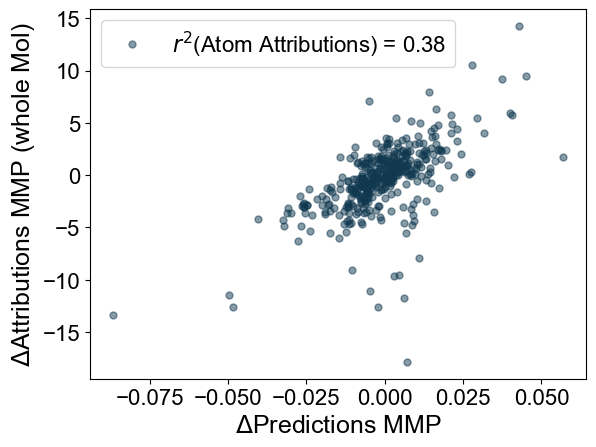

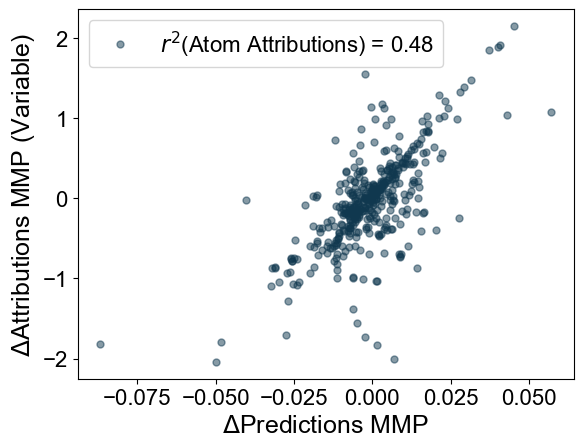

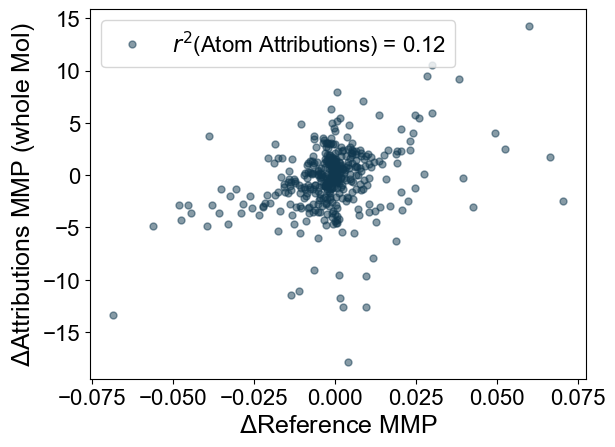

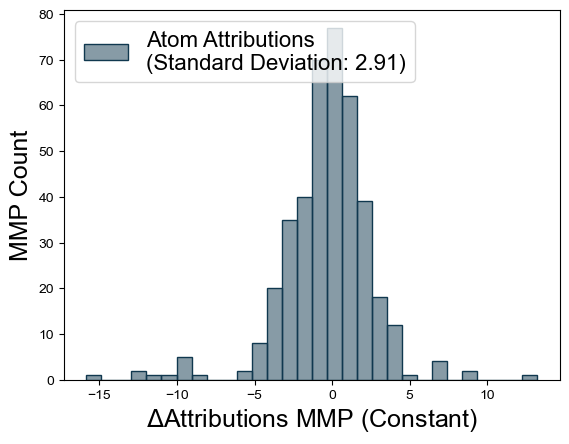

delta_sum_Atom Attributions Accuracy: 0.78
delta_sum_fragment_contributions_Atom Attributions Accuracy: 0.74
WISP done


In [ ]:
# Integrating the new get_feature_function into WISPs namespace
wisp.get_mbtr_desc = get_mbtr_desc

# Executing WISP
data = WISP(
    'output/',
    'dataset/qm8_subset.csv',
    'mol_id',
    "smiles",
    'E1-CC2',
    model_available=True,
)
